In [148]:
import pandas as pd
import numpy as np
import datetime

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *

In [149]:
%matplotlib inline

In [150]:
# mercy ships
ORG = 436247

# load data

In [151]:
START_DATE = '2020-10-01'

In [152]:
# form status
q = "select id, status, org from form where org={}"
all_forms = redshift_query_read(q.format(ORG), schema='production')
active_forms = all_forms[all_forms['status']==1]['id'].tolist()

In [153]:
FORMS = all_forms['id'].tolist()

In [154]:
print("{:,} forms".format(len(all_forms)))
print("{:,} forms with active status".format(len(active_forms)))

992 forms
90 forms with active status


### embeds

In [155]:
# embeds
q = "select widget as form from embed"
embeds = redshift_query_read(q, schema='production')
embeds = embeds[embeds['form'].isin(FORMS)]

In [156]:
def is_embed(r):
    if r['form'] in embeds['form'].unique().tolist():
        return True
    return False

### form upgrades

In [157]:
# logged upgrades
q = "select * from syslog_logs where org={} and message like '%Qgiv Form Template Upgraded%'"
form_upgrades = redshift_query_read(q.format(ORG), schema="production")[['org', 'form', 'created']]
forms_upgrades_ids_logged = form_upgrades['form'].unique().tolist()

In [158]:
print("first form upgrade: {}".format(form_upgrades['created'].min()))
print("last form upgrade: {}".format(form_upgrades['created'].max()))

first form upgrade: 2021-03-30 08:49:38
last form upgrade: 2021-06-29 14:00:18


In [159]:
# created new template forms
bucket = "qgiv-stats-data"
new_form_template_list = "form_download.csv"
new_forms = get_dataframe_from_file(bucket, new_form_template_list)

new_forms = new_forms[new_forms['Form ID'].isin(FORMS)]

new_forms['Go Live Date'] = pd.to_datetime(new_forms['Go Live Date'])

new_forms = new_forms[~new_forms['Form ID'].isin(forms_upgrades_ids_logged)]
new_forms = new_forms[(new_forms['Status']=='active')&(new_forms['Go Live Date']>=START_DATE)]
new_forms_ids = new_forms['Form ID'].unique().tolist()

In [160]:
print("{:,} forms upgraded (noted in logs)".format(len(forms_upgrades_ids_logged)))
print("{:,} forms with new template (production export)".format(len(new_forms)))
print("{:,} forms with new template and active status (production export)".format(len(new_forms_ids)))
print()
print("{:,} new template forms & active".format(len([f for f in set(forms_upgrades_ids_logged + new_forms_ids) if f in active_forms])))
print("\n\nlog entries do not imply form status, so here we see an excess but status filters will be applied to remove non-active forms from the dataset")

2 forms upgraded (noted in logs)
83 forms with new template (production export)
83 forms with new template and active status (production export)

34 new template forms & active


log entries do not imply form status, so here we see an excess but status filters will be applied to remove non-active forms from the dataset


In [161]:
new_forms['month'] = new_forms['Go Live Date'].dt.to_period('m')

print("created new template forms")
new_forms.groupby('month')['Form ID'].count().reset_index()

created new template forms


,month,Form ID
0,2021-06,1
1,2021-07,3
2,2021-08,11
3,2021-09,10
4,2021-10,1
5,2021-11,36
6,2021-12,21


In [162]:
def is_new_template(daily_row):
    try:
        # check for log conversion
        if daily_row['form'] in form_upgrades['form'].unique().tolist():
            # is date after logged upgrade date?
            return daily_row['date'] >= form_upgrades[form_upgrades['form']==daily_row['form']]['created'].iloc[0]
        else:
            # form created as new form template
            return daily_row['form'] in new_forms_ids
    except:
        print("error with form {}".format(daily_row['form']))
        raise Exception

### transactions

In [163]:
q_trans_onetime = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        org={} and
                        date>='{}' and
                        status='A' and 
                        recurring=0 and
                        (source='don_form' or source='mobile')'''
trans_onetime = redshift_query_read(q_trans_onetime.format(ORG, START_DATE), schema='production')
trans_onetime['is_recurring'] = False

trans_onetime = trans_onetime[trans_onetime['id']!=12774333]

### transactions

In [164]:
print("{:,} transactions, {:,} unique".format(len(trans_onetime), len(trans_onetime['id'].unique())))
print("{:,} forms".format(len(trans_onetime['form'].unique())))

72,491 transactions, 72,491 unique
328 forms


In [165]:
q_trans_onetime = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        org={} and
                        date>='{}' and
                        status='A' and 
                        recurring=0 and
                        (source='don_form' or source='mobile')'''
trans_onetime = redshift_query_read(q_trans_onetime.format(ORG, START_DATE), schema='production')
trans_onetime['is_recurring'] = False

trans_onetime = trans_onetime[trans_onetime['id']!=12774333]

In [166]:
print("{:,} transactions, {:,} unique".format(len(trans_onetime), len(trans_onetime['id'].unique())))
print("{:,} forms".format(len(trans_onetime['form'].unique())))

72,491 transactions, 72,491 unique
328 forms


In [167]:
q_trans_rec = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        org={} and
                        date>='{}' and
                        status='A' and 
                        recurring!=0 and
                        (source='don_form' or source='mobile')'''
trans_rec = redshift_query_read(q_trans_rec.format(ORG, START_DATE), schema='production')
trans_rec['is_recurring'] = True

trans_rec = trans_rec[trans_rec['id']!=12774333]

In [168]:
print("{:,} recurring transactions, {:,} unique".format(len(trans_rec), len(trans_rec['id'].unique())))
print("{:,} forms".format(len(trans_rec['form'].unique())))

341,644 recurring transactions, 341,644 unique
480 forms


In [169]:
trans = trans_onetime.append(trans_rec)

In [170]:
print("forms: {:,}".format(trans['form'].nunique()))
print("transactions: {:,}, {:,} unique".format(len(trans), trans['id'].nunique()))
print("one time transactions: {:,}, {:,} unique".format(len(trans[~trans['is_recurring']]), trans[~trans['is_recurring']]['id'].nunique()))
print("recurring transactions: {:,}, {:,} unique".format(len(trans[trans['is_recurring']]), trans[trans['is_recurring']]['id'].nunique()))

forms: 560
transactions: 414,135, 414,135 unique
one time transactions: 72,491, 72,491 unique
recurring transactions: 341,644, 341,644 unique


In [171]:
trans['date'].min(), trans['date'].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2022-03-02 00:00:00'))

### traffic

In [172]:
q_ga = '''select
                date,
                form,
                devicecategory,
                views,
                bounces
            from googleanalytics_traffic
            where
                org={} and
                date>='{}' and
                (qgiv_frontend=1 or p2p_frontend=1) and
                path not like '%/receipt/%' '''
traffic = redshift_query_read(q_ga.format(ORG, START_DATE), schema='production')

In [173]:
traffic = traffic.drop_duplicates()

In [174]:
print("{:,} entries; {:,} unique".format(len(traffic), len(traffic.drop_duplicates())))
print("{:,.2f} entries per form".format(traffic.groupby('form')['views'].count().mean()))
print("{:,.2f} observation dates per form".format(traffic.groupby('form')['date'].nunique().mean()))
print("{:,.2f} views per form".format(traffic.groupby('form')['views'].sum().mean()))
print("{:,.2f} views per form per day".format(traffic.groupby(['form', 'date'])['views'].sum().mean()))

42,932 entries; 42,932 unique
76.53 entries per form
32.96 observation dates per form
2,486.22 views per form
75.43 views per form per day


### merge & compile data

In [175]:
traffic['date'].min(), traffic['date'].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2022-02-03 00:00:00'))

In [176]:
trans['is embed'] = trans['form'].isin(embeds['form'].tolist())

In [177]:
trans['is new template'] = trans[['form', 'date']].apply(is_new_template, axis=1)

In [178]:
trans_all = trans.copy()

trans_onetime = trans[~trans['is_recurring']]
trans_rec = trans[trans['is_recurring']]
trans_rec = trans_rec.groupby('recurring').first().reset_index()

trans = trans_onetime.append(trans_rec)

In [179]:
print("All transactions: {:,} ({:,} unique)".format(len(trans_all), len(trans_all['id'].unique())))
print("One time and originating recurring: {:,}".format(len(trans)))
print()
print("Trans per form: {:,.2f}".format(trans.groupby('form')['amount'].count().mean()))
print("Trans per form per day: {:,.2f}".format(trans.groupby(['form', 'date'])['amount'].count().mean()))
print("One time trans per form: {:,.2f}".format(trans[~trans['is_recurring']].groupby('form')['amount'].count().mean()))
print("Recurring trans per form: {:,.2f}".format(trans[trans['is_recurring']].groupby('form')['amount'].count().mean()))

All transactions: 414,135 (414,135 unique)
One time and originating recurring: 106,442

Trans per form: 190.07
Trans per form per day: 9.03
One time trans per form: 221.01
Recurring trans per form: 70.73


#### daily (all devices) data

In [180]:
# merge to daily
daily_trans = trans.groupby(['form', 'date', 'is_recurring', 'is new template', 'is embed'])['amount'].agg({'count', 'sum'}).reset_index()
daily_trans['trans_count'] = daily_trans['count']
daily_trans['trans_vol'] = daily_trans['sum']
daily_trans.drop(['count', 'sum'], axis=1, inplace=True)

daily_trans_pvt = daily_trans.pivot(index=['form', 'date', 'is new template', 'is embed'], columns='is_recurring', values=['trans_count', 'trans_vol']).reset_index()
cols = ['form', 'date', 'is new template', 'is embed', 
        'trans_count_onetime', 'trans_count_recurring', 
        'trans_vol_onetime', 'trans_vol_recurring']
daily_trans_pvt.columns = cols
daily_trans_pvt.fillna(0, inplace=True)

traffic_agg = traffic.groupby(['date', 'form'])[['views', 'bounces']].sum().reset_index()
dailies = traffic_agg.merge(daily_trans_pvt, on=['date', 'form'], how='outer')
dailies.fillna(0, inplace=True)
dailies = dailies[dailies['views']>0]

In [181]:
print("daily trans agg len: {:,}".format(len(daily_trans)))
print("daily traffic agg len: {:,}".format(len(traffic_agg)))
print("merged dailies len: {:,}".format(len(dailies)))

daily trans agg len: 15,006
daily traffic agg len: 18,492
merged dailies len: 18,486


In [182]:
# merge to daily
daily_trans = trans.groupby(['form', 'date', 'is_recurring', 'is new template', 'is embed'])['amount'].agg({'count', 'sum'}).reset_index()
daily_trans['trans_count'] = daily_trans['count']
daily_trans['trans_vol'] = daily_trans['sum']
daily_trans.drop(['count', 'sum'], axis=1, inplace=True)

daily_trans_pvt = daily_trans.pivot(index=['form', 'date', 'is new template', 'is embed'], columns='is_recurring', values=['trans_count', 'trans_vol']).reset_index()
cols = ['form', 'date', 'is new template', 'is embed', 
        'trans_count_onetime', 'trans_count_recurring', 
        'trans_vol_onetime', 'trans_vol_recurring']
daily_trans_pvt.columns = cols
daily_trans_pvt.fillna(0, inplace=True)

traffic_agg = traffic.groupby(['date', 'form'])[['views', 'bounces']].sum().reset_index()
dailies = traffic_agg.merge(daily_trans_pvt, on=['date', 'form'], how='outer')
dailies.fillna(0, inplace=True)
dailies = dailies[dailies['views']>0]

In [183]:
print("daily trans agg len: {:,}".format(len(daily_trans)))
print("daily traffic agg len: {:,}".format(len(traffic_agg)))
print("merged dailies len: {:,}".format(len(dailies)))

daily trans agg len: 15,006
daily traffic agg len: 18,492
merged dailies len: 18,486


In [184]:
print("{:,} forms in transaction aggregates".format(len(daily_trans['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies['form'].unique())))
print()

print("2021-07-22:")
print("-"*40)
print("{:,} forms in transaction aggregates".format(len(daily_trans[daily_trans['date']=='2021-07-22']['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg[traffic_agg['date']=='2021-07-22']['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies[dailies['date']=='2021-07-22']['form'].unique())))
print()
print("{:,} one time transactions from transactions data".format(len(trans[(trans['date']=='2021-07-22')&(trans['recurring']==0)])))
print("{:,} one time transactions from transactions aggregated data".format(daily_trans_pvt[(daily_trans_pvt['date']=='2021-07-22')]['trans_count_onetime'].sum()))
print("{:,} forms in merged dailies".format(dailies[dailies['date']=='2021-07-22']['trans_count_onetime'].sum()))
print()

print("2021-05-29:")
print("-"*40)
print("{:,} forms in transaction aggregates".format(len(daily_trans[daily_trans['date']=='2021-05-29']['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg[traffic_agg['date']=='2021-05-29']['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies[dailies['date']=='2021-05-29']['form'].unique())))
print()
print("{:,} one time transactions from transactions data".format(len(trans[(trans['date']=='2021-05-29')&(trans['recurring']==0)]['id'].unique())))
print("{:,} one time transactions from transactions aggregated data".format(daily_trans_pvt[(daily_trans_pvt['date']=='2021-05-29')]['trans_count_onetime'].sum()))
print("{:,} forms in merged dailies".format(dailies[dailies['date']=='2021-05-29']['trans_count_onetime'].sum()))
print()

print("Dailies w/ > 0 transactions and 0 pageviews:")
print("-"*40)
print("{:,} total dailies entries".format(len(dailies)))
print("{:,} entries".format(len(dailies[(dailies['views']==0)&(dailies['trans_count_onetime']>0)])))
print("{:,} forms".format(len(dailies[(dailies['views']==0)&(dailies['trans_count_onetime']>0)]['form'].unique())))

560 forms in transaction aggregates
561 forms in traffic aggregates
561 forms in merged dailies

2021-07-22:
----------------------------------------
21 forms in transaction aggregates
42 forms in traffic aggregates
42 forms in merged dailies

74 one time transactions from transactions data
74.0 one time transactions from transactions aggregated data
70.0 forms in merged dailies

2021-05-29:
----------------------------------------
18 forms in transaction aggregates
30 forms in traffic aggregates
30 forms in merged dailies

142 one time transactions from transactions data
142.0 one time transactions from transactions aggregated data
120.0 forms in merged dailies

Dailies w/ > 0 transactions and 0 pageviews:
----------------------------------------
18,486 total dailies entries
0 entries
0 forms


In [185]:
dailies['conversion'] = (dailies['trans_count_onetime'] + dailies['trans_count_recurring']) / dailies['views']
dailies['conversion_onetime'] = dailies['trans_count_onetime'] / dailies['views']
dailies['conversion_recurring'] = dailies['trans_count_recurring'] / dailies['views']

In [186]:
# removing outliers
dailies = dailies[dailies['conversion']<1.]

In [187]:
dailies = dailies[dailies['date']>=START_DATE]

In [188]:
# limiting to prior report range
dailies = dailies[dailies['date']<='2022-02-01']

In [189]:
# need to tag embed & new template by prior entries for 0 transaction days
dailies['is new template'] = dailies[['form', 'date']].apply(is_new_template, axis=1)

In [190]:
dailies['is embed'] = dailies['form'].isin(embeds['form'].tolist())

In [191]:
count_new_template_onetime = dailies[dailies['is new template']]['trans_count_onetime'].sum()
count_new_template_rec = dailies[dailies['is new template']]['trans_count_recurring'].sum()
count_old_template_onetime = dailies[~dailies['is new template']]['trans_count_onetime'].sum()
count_old_template_rec = dailies[~dailies['is new template']]['trans_count_recurring'].sum()
count_new_template = count_new_template_onetime + count_new_template_rec
count_old_template = count_old_template_onetime + count_old_template_rec

perc_new_template_onetime = (count_new_template_onetime / (count_new_template_onetime + count_old_template_onetime)) * 100.
perc_new_template_rec = (count_new_template_rec / (count_new_template_rec + count_old_template_rec)) * 100.
perc_new_template = (count_new_template / (count_new_template + count_old_template)) * 100.

print("{:,} daily aggregate observations old template".format(len(dailies[~dailies['is new template']])))
print("{:,} daily aggregate observations new template".format(len(dailies[dailies['is new template']])))
print()
print("{:,} ({:.2f}%) transactions new template".format(count_new_template, perc_new_template))
print("{:,} ({:.2f}%) onetime transactions new template".format(count_new_template_onetime, perc_new_template_onetime))
print("{:,} ({:.2f}%) recurring transactions new template".format(count_new_template_rec, perc_new_template_rec))

15,861 daily aggregate observations old template
1,291 daily aggregate observations new template

13,843.0 (24.46%) transactions new template
12,026.0 (26.64%) onetime transactions new template
1,817.0 (15.85%) recurring transactions new template


In [192]:
dailies['date'].min(), dailies['date'].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2022-02-01 00:00:00'))

# exploration

In [193]:
len_old_temp_zero_conv = len(dailies[(~dailies['is new template'])&(dailies['conversion']==0.0)])
perc_old_temp_zero_conv = (len_old_temp_zero_conv / len(dailies[~dailies['is new template']])) * 100.

len_new_temp_zero_conv = len(dailies[(dailies['is new template'])&(dailies['conversion']==0.0)])
perc_new_temp_zero_conv = (len_new_temp_zero_conv / len(dailies[dailies['is new template']])) * 100.

print("{:,} ({:.2f}%) old template observations w/ 0% conversion".format(len_old_temp_zero_conv, perc_old_temp_zero_conv))
print("{:,} ({:.2f}%) new template observations w/ 0% conversion".format(len_new_temp_zero_conv, perc_new_temp_zero_conv))

11,599 (73.13%) old template observations w/ 0% conversion
625 (48.41%) new template observations w/ 0% conversion


In [194]:
template_date_counts = dailies.groupby(['date', 'is new template'])['conversion'].count().reset_index()
template_date_counts = template_date_counts.pivot(index='date', columns='is new template', values='conversion').reset_index()
template_date_counts.columns = ['date', 'old template', 'new template']

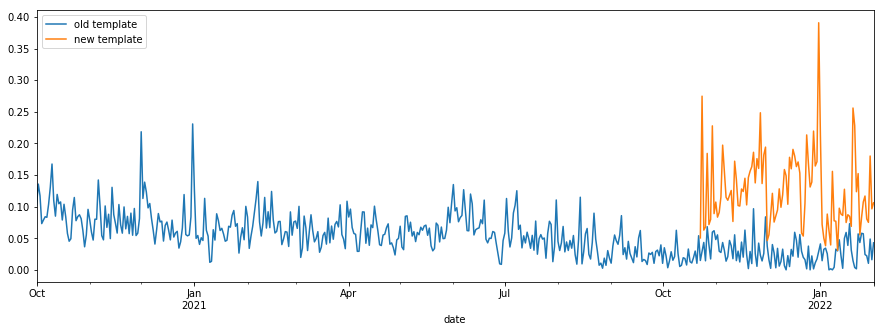

In [195]:
template_date_conv = dailies.groupby(['date', 'is new template'])['conversion'].mean().reset_index()
template_date_conv = template_date_conv.pivot(index='date', columns='is new template', values='conversion').reset_index()
template_date_conv.columns = ['date', 'old template', 'new template']
template_date_conv.plot(x='date', figsize=(15,5))

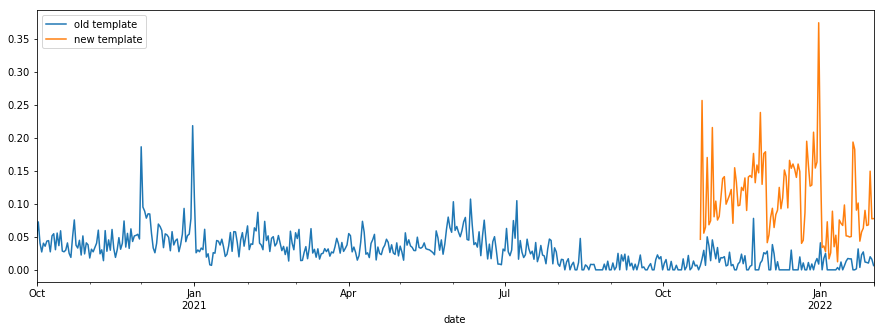

In [196]:
temp_ot_date_conv = dailies.groupby(['date', 'is new template'])['conversion_onetime'].mean().reset_index()
temp_ot_date_conv = temp_ot_date_conv.pivot(index='date', columns='is new template', values='conversion_onetime').reset_index()
temp_ot_date_conv.columns = ['date', 'old template', 'new template']
temp_ot_date_conv.plot(x='date', figsize=(15,5))

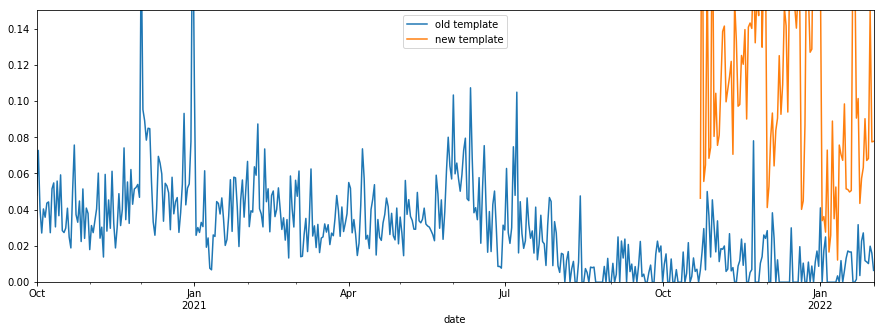

In [197]:
temp_ot_date_conv.plot(x='date', figsize=(15,5), ylim=(0,0.15))

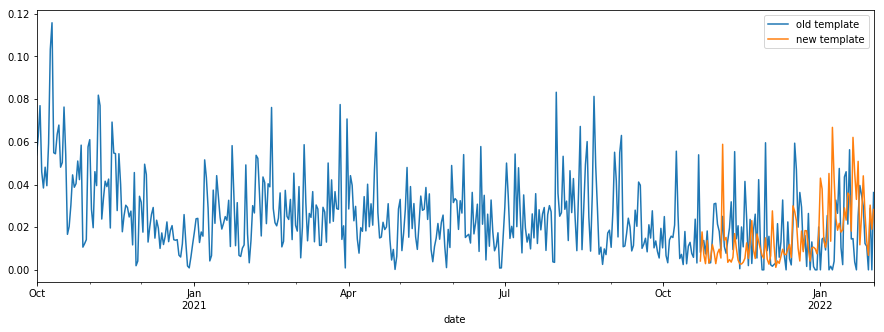

In [198]:
temp_rec_date_conv = dailies.groupby(['date', 'is new template'])['conversion_recurring'].mean().reset_index()
temp_rec_date_conv = temp_rec_date_conv.pivot(index='date', columns='is new template', values='conversion_recurring').reset_index()
temp_rec_date_conv.columns = ['date', 'old template', 'new template']
temp_rec_date_conv.plot(x='date', figsize=(15,5))

In [199]:
dailies[dailies['is new template']].sort_values('conversion_recurring', ascending=False).head()

,date,form,views,bounces,is new template,is embed,trans_count_onetime,trans_count_recurring,trans_vol_onetime,trans_vol_recurring,conversion,conversion_onetime,conversion_recurring
17562,2022-01-06,981920,2.0,2.0,True,False,0.0,1.0,0.0,41.20,0.500000,0.0,0.500000
17628,2022-01-08,975940,2.0,2.0,True,False,0.0,1.0,0.0,300.00,0.500000,0.0,0.500000
18227,2022-01-26,980858,12.0,9.0,True,False,0.0,5.0,0.0,153.75,0.416667,0.0,0.416667
18123,2022-01-23,980858,47.0,38.0,True,False,0.0,16.0,0.0,638.52,0.340426,0.0,0.340426
17668,2022-01-09,980234,3.0,3.0,True,False,0.0,1.0,0.0,100.00,0.333333,0.0,0.333333


In [200]:
len(dailies), len(dailies[dailies['conversion']>1.]), "{:.2f}%".format((len(dailies[dailies['conversion']>1.]) / len(dailies)) * 100.)

(17152, 0, '0.00%')

In [201]:
over_conv_forms = dailies[dailies['conversion']>1.]['form'].unique().tolist()
intersect_over_conv = [f for f in over_conv_forms if f in dailies[dailies['conversion']<1.]['form'].unique()]

print("{:,} forms w/ > 100% conversion".format(len(over_conv_forms)))
print("{:,} forms overlap w/ < 100% conversion".format(len(intersect_over_conv)))

0 forms w/ > 100% conversion
0 forms overlap w/ < 100% conversion


In [202]:
print(len(dailies[dailies['conversion_onetime']>1.]), len(dailies[dailies['conversion_recurring']>1.]))
print("one time: {:.2f}%".format((len(dailies[dailies['conversion_onetime']>1.]) / len(dailies)) * 100.))
print("recurring: {:.2f}%".format((len(dailies[dailies['conversion_recurring']>1.]) / len(dailies)) * 100.))

0 0
one time: 0.00%
recurring: 0.00%


In [203]:
print("total: {:,}".format(len(dailies[dailies['conversion']>1.])))
print("new template: {:,}".format(len(dailies[(dailies['is new template'])&(dailies['conversion']>1.)])))
print("old template: {:,}".format(len(dailies[(dailies['conversion']>1.)&(~dailies['is new template'])])))
print("embed: {:,}".format(len(dailies[(dailies['conversion']>1.)&(dailies['is embed'])])))
print("not embed: {:,}".format(len(dailies[(dailies['conversion']>1.)&(~dailies['is embed'])])))

print()
print("old template & embed: {:,}".format(len(dailies[(~dailies['is new template'])&(dailies['is embed'])&(dailies['conversion']>1.)])))

total: 0
new template: 0
old template: 0
embed: 0
not embed: 0

old template & embed: 0


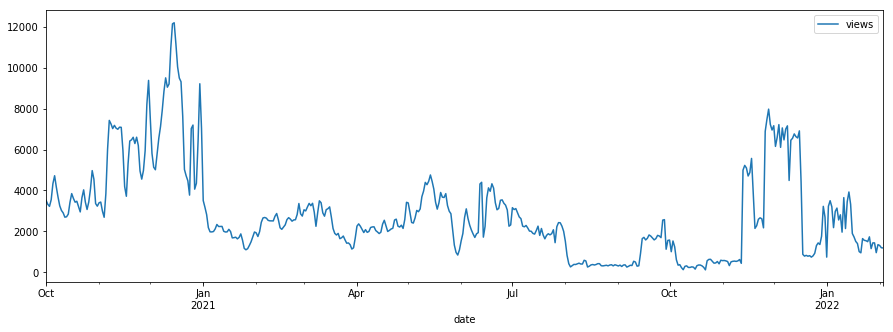

In [204]:
traff_date = traffic.groupby('date')['views'].sum().reset_index()
traff_date.plot(x='date', figsize=(15,5))

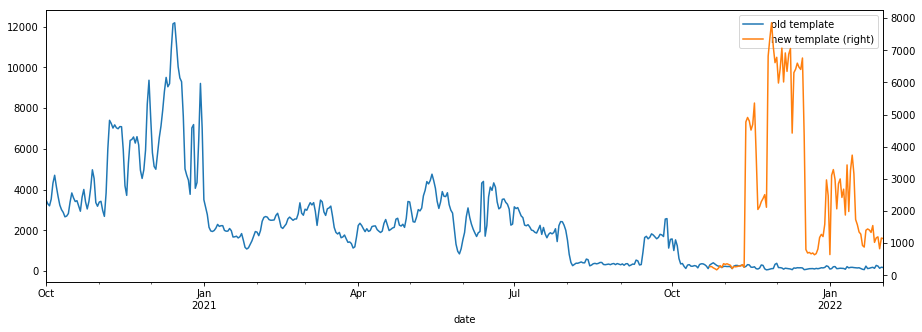

In [205]:
template_date_traf = dailies.groupby(['date', 'is new template'])['views'].sum().reset_index()
template_date_traf = template_date_traf.pivot(index='date', columns='is new template', values='views').reset_index()
template_date_traf.columns = ['date', 'old template', 'new template']
template_date_traf.plot(x='date', secondary_y='new template', figsize=(15,5))

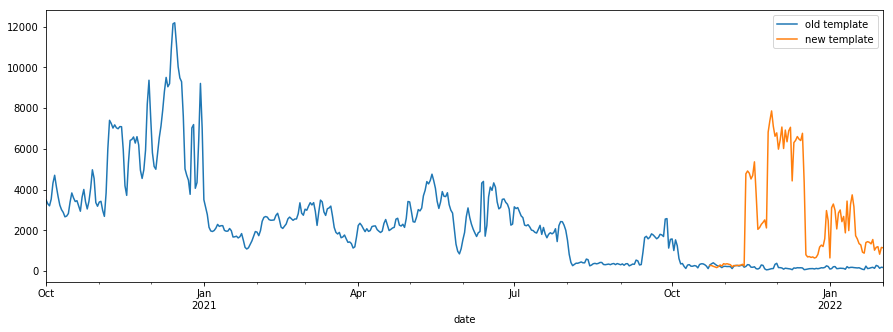

In [206]:
template_date_traf.plot(x='date', figsize=(15,5))

In [207]:
dailies['trans_count'] = dailies['trans_count_onetime'] + dailies['trans_count_recurring']

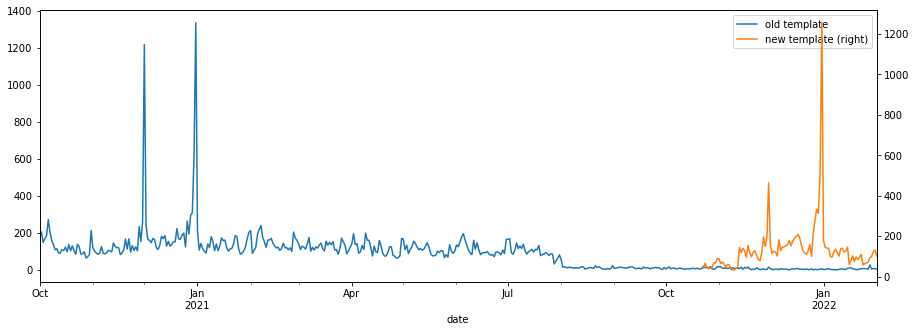

In [208]:
template_date_trans = dailies.groupby(['date', 'is new template'])['trans_count'].sum().reset_index()
template_date_trans = template_date_trans.pivot(index='date', columns='is new template', values='trans_count').reset_index()
template_date_trans.columns = ['date', 'old template', 'new template']
template_date_trans.plot(x='date', secondary_y='new template', figsize=(15,5))

In [209]:
dailies['trans_vol'] = dailies['trans_vol_onetime'] + dailies['trans_vol_recurring']

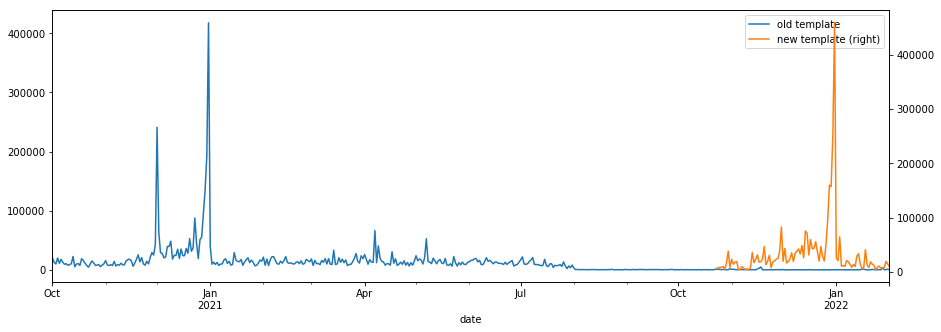

In [210]:
template_date_trans = dailies.groupby(['date', 'is new template'])['trans_vol'].sum().reset_index()
template_date_trans = template_date_trans.pivot(index='date', columns='is new template', values='trans_vol').reset_index()
template_date_trans.columns = ['date', 'old template', 'new template']
template_date_trans.plot(x='date', secondary_y='new template', figsize=(15,5))

In [211]:
template_date_trans.iloc[-28:-23]

,date,old template,new template
461,2022-01-05,77.71,11751.59
462,2022-01-06,0.00,9872.29
463,2022-01-07,50.00,20995.92
464,2022-01-08,0.00,18532.72
465,2022-01-09,19.57,14189.03


_Re: new template spike on 10-04, secure reports for donation form processing shows a similar spike so it appears legit_

#### monthly median transactions

In [212]:
trans['month'] = trans['date'].dt.to_period('M')
trans_monthly_median = trans[~trans['is_recurring']].groupby(['month', 'is new template'])['amount'].agg({'median', 'count'}).reset_index()

In [213]:
monthly_medians = trans_monthly_median.pivot(index='month', columns='is new template', values=['count', 'median']).reset_index()
monthly_medians.columns = ['month', 'old template count', 'new template count', 'old template median', 'new template median']

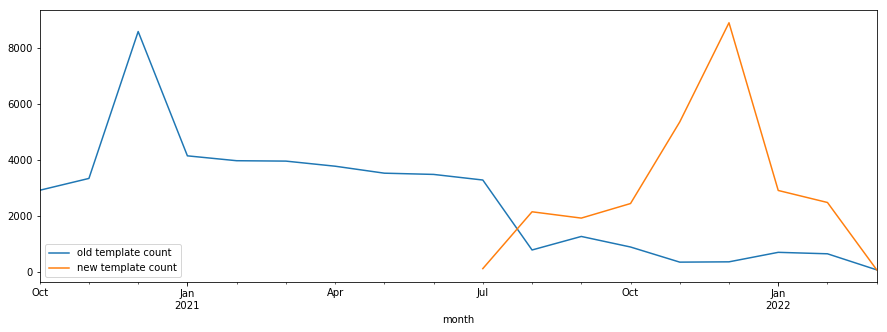

In [214]:
monthly_medians.plot(x='month', y=['old template count', 'new template count'], figsize=(15,5))

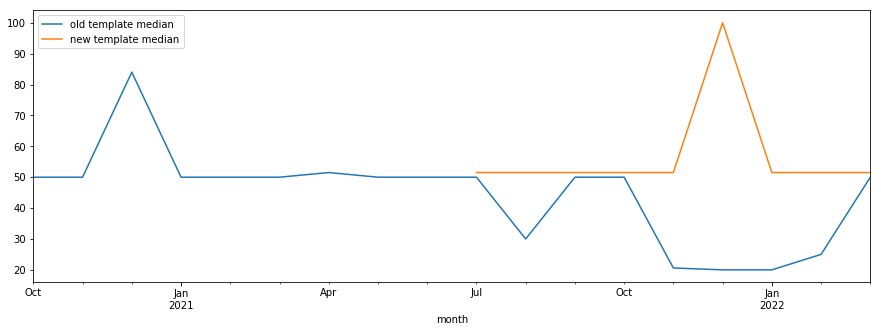

In [215]:
monthly_medians.plot(x='month', y=['old template median', 'new template median'], figsize=(15,5))

In [216]:
trans_monthly_sums = trans[~trans['is_recurring']].groupby(['month', 'is new template'])['amount'].sum().reset_index()

In [217]:
monthly_sums = trans_monthly_sums.pivot(index='month', columns='is new template', values=['amount']).reset_index()
monthly_sums.columns = ['month', 'old template vol', 'new template vol']

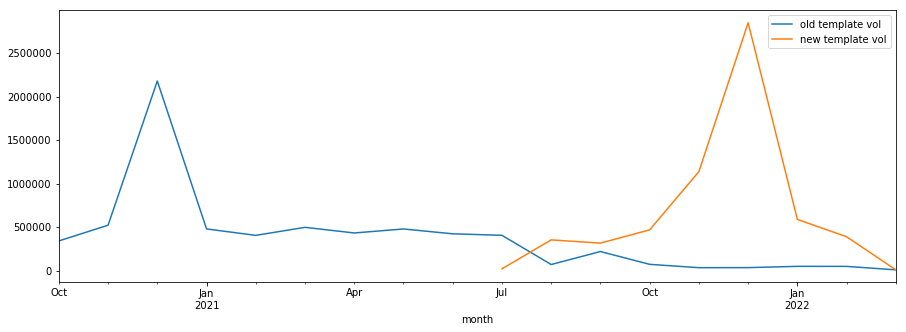

In [218]:
monthly_sums.plot(x='month', figsize=(15,5))

In [219]:
trans_monthly_counts = trans.groupby(['month', 'is new template', 'is_recurring'])['id'].nunique().reset_index()
trans_monthly_counts = trans_monthly_counts.pivot(index='month', columns=['is new template', 'is_recurring'], values='id').reset_index()
trans_monthly_counts.columns = ['month', 'one time old template', 
                                'recurring old template', 'one time new template',
                                'recurring new template']

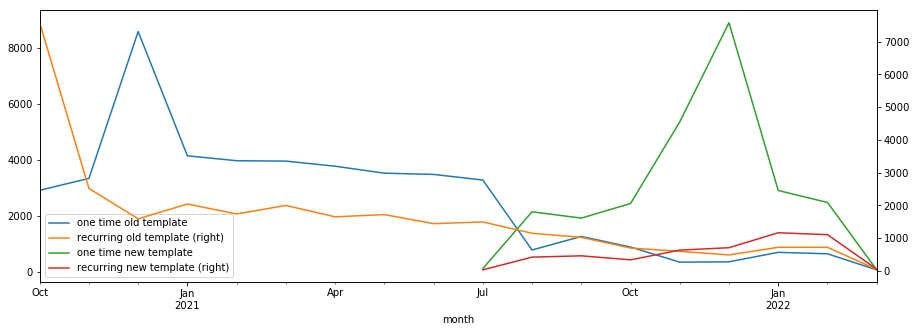

In [220]:
secondary_ys = ['recurring old template', 'recurring new template']
trans_monthly_counts.plot(x='month', secondary_y=secondary_ys, figsize=(15,5))

#### monthly onetime/recurring ratio

In [221]:
trans['month'] = trans['date'].dt.to_period('m')
monthly_ratios = trans.groupby(['month', 'is_recurring', 'is new template'])['id'].nunique().reset_index()

In [222]:
monthly_ratios = monthly_ratios.pivot(index='month', columns=['is_recurring', 'is new template'], values='id').reset_index()
monthly_ratios.columns = ['month', 'onetime old template', 'onetime new template', 'recurring old template', 'recurring new template']
monthly_ratios['new template ratio'] = monthly_ratios['onetime new template'] / monthly_ratios['recurring new template']
monthly_ratios['old template ratio'] = monthly_ratios['onetime old template'] / monthly_ratios['recurring old template']

In [223]:
monthly_ratios.tail(12)

,month,onetime old template,onetime new template,recurring old template,recurring new template,new template ratio,old template ratio
6,2021-04,3778.0,1645.0,NaN,NaN,NaN,NaN
7,2021-05,3529.0,1713.0,NaN,NaN,NaN,NaN
8,2021-06,3485.0,1436.0,NaN,NaN,NaN,NaN
9,2021-07,3285.0,1488.0,123.0,23.0,64.695652,26.707317
10,2021-08,788.0,1141.0,2151.0,412.0,2.769417,0.366341
11,2021-09,1271.0,1018.0,1926.0,452.0,2.252212,0.659917
12,2021-10,894.0,690.0,2446.0,329.0,2.097264,0.365495
13,2021-11,354.0,590.0,5359.0,627.0,0.940989,0.066057
14,2021-12,365.0,479.0,8898.0,700.0,0.684286,0.041020
15,2022-01,704.0,714.0,2912.0,1158.0,0.616580,0.241758


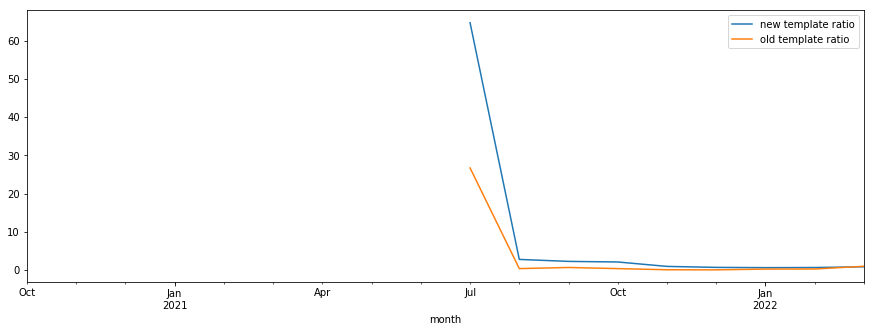

In [224]:
monthly_ratios[['month', 'new template ratio', 'old template ratio']].plot(x='month', figsize=(15,5))

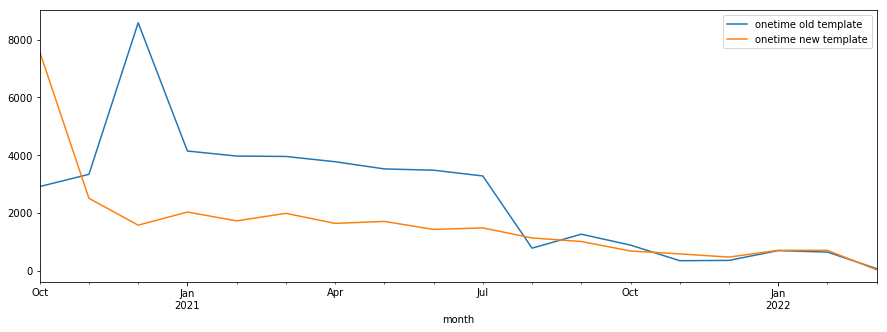

In [225]:
monthly_ratios[['month', 'onetime old template', 'onetime new template']].plot(x='month', figsize=(15,5))

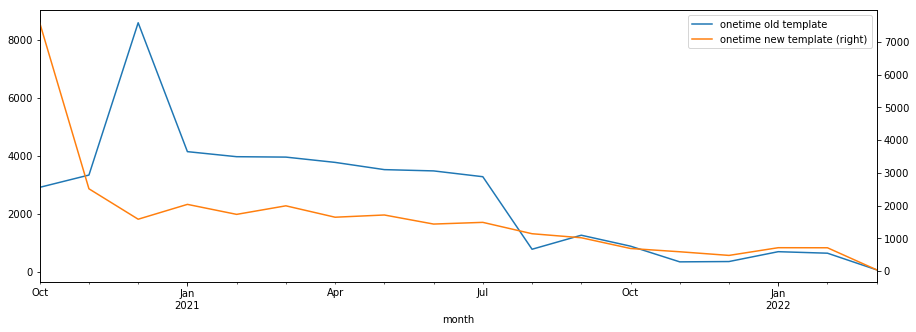

In [226]:
monthly_ratios[['month', 'onetime old template', 'onetime new template']].plot(x='month', secondary_y='onetime new template', figsize=(15,5))

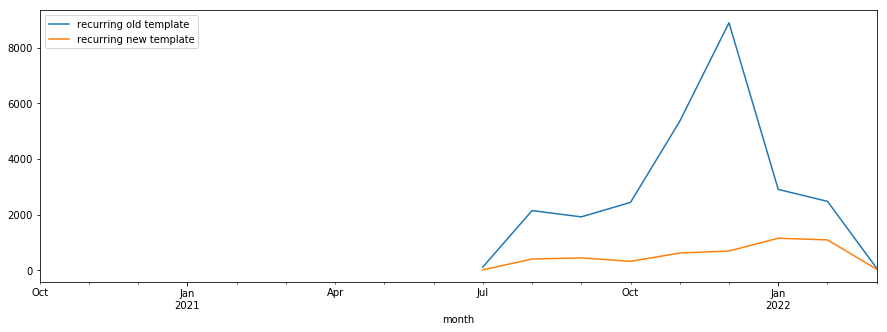

In [227]:
monthly_ratios[['month', 'recurring old template', 'recurring new template']].plot(x='month', figsize=(15,5))

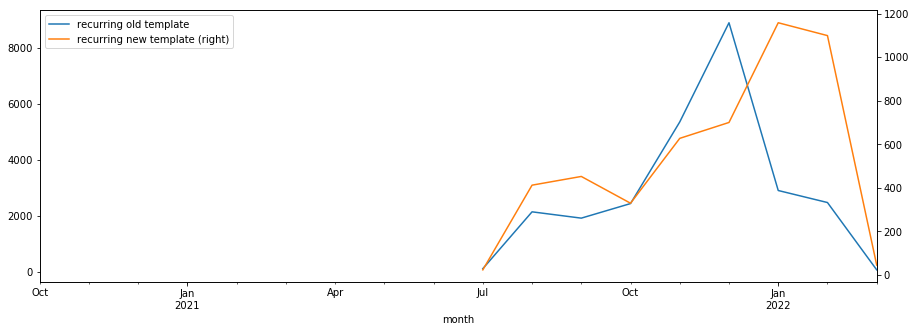

In [228]:
monthly_ratios[['month', 'recurring old template', 'recurring new template']].plot(x='month', secondary_y='recurring new template', figsize=(15,5))

- one time / recurring over time, one time, recurring, recurring all vs originating
- over time, table

In [229]:
daily_onetime = trans[~trans['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_onetime = daily_onetime.pivot(index='date', columns='is new template', values='id').reset_index()
daily_onetime.columns = ['date', 'old template onetime', 'new template onetime']

daily_rec_originating = trans[trans['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_rec_originating = daily_rec_originating.pivot(index='date', columns='is new template', values='id').reset_index()
daily_rec_originating.columns = ['date', 'old template rec origin', 'new template rec origin']

daily_rec_all = trans_all[trans_all['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_rec_all = daily_rec_all.pivot(index='date', columns='is new template', values='id').reset_index()
daily_rec_all.columns = ['date', 'old template rec all', 'new template rec all']

daily_trans = daily_onetime.merge(daily_rec_originating, on='date', how='outer').merge(daily_rec_all, on='date', how='outer')

In [230]:
daily_trans.tail(3)

,date,old template onetime,new template onetime,old template rec origin,new template rec origin,old template rec all,new template rec all
515,2022-02-28,47.0,80.0,57.0,72.0,1674.0,520.0
516,2022-03-01,77.0,77.0,37.0,45.0,799.0,176.0
517,2022-03-02,2.0,4.0,1.0,NaN,2.0,NaN


In [231]:
daily_trans['new template onetime / rec origin'] = daily_trans['new template onetime'] / daily_trans['new template rec origin']
daily_trans['new template onetime / rec all'] = daily_trans['new template onetime'] / daily_trans['new template rec all']

daily_trans['old template onetime / rec origin'] = daily_trans['old template onetime'] / daily_trans['old template rec origin']
daily_trans['old template onetime / rec all'] = daily_trans['old template onetime'] / daily_trans['old template rec all']

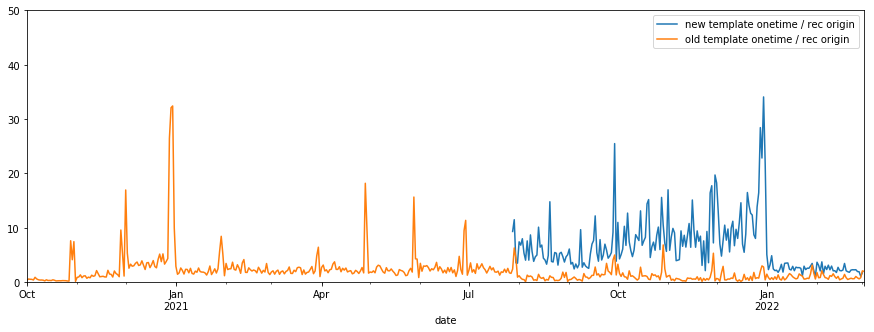

In [232]:
cols = ['date', 'new template onetime / rec origin', 
        'old template onetime / rec origin']
daily_trans[cols].plot(x='date', ylim=(0,50), figsize=(15,5))

In [233]:
cols = ['old template onetime', 'new template onetime',
       'old template rec origin', 'new template rec origin',
       'old template rec all', 'new template rec all']
monthly_trans = daily_trans.groupby(daily_trans['date'].dt.to_period('m'))[cols].sum().reset_index()

In [234]:
monthly_trans['new template onetime / rec origin'] = monthly_trans['new template onetime'] / monthly_trans['new template rec origin']
monthly_trans['new template onetime / rec all'] = monthly_trans['new template onetime'] / monthly_trans['new template rec all']

monthly_trans['old template onetime / rec origin'] = monthly_trans['old template onetime'] / monthly_trans['old template rec origin']
monthly_trans['old template onetime / rec all'] = monthly_trans['old template onetime'] / monthly_trans['old template rec all']

In [235]:
monthly_trans

,date,old template onetime,new template onetime,old template rec origin,new template rec origin,old template rec all,new template rec all,new template onetime / rec origin,new template onetime / rec all,old template onetime / rec origin,old template onetime / rec all
0,2020-10,2919.0,0.0,7583.0,0.0,15144.0,0.0,NaN,NaN,0.384940,0.192750
1,2020-11,3342.0,0.0,2513.0,0.0,15229.0,0.0,NaN,NaN,1.329885,0.219450
2,2020-12,8585.0,0.0,1584.0,0.0,15966.0,0.0,NaN,NaN,5.419823,0.537705
3,2021-01,4148.0,0.0,2037.0,0.0,18353.0,0.0,NaN,NaN,2.036328,0.226012
4,2021-02,3974.0,0.0,1732.0,0.0,18735.0,0.0,NaN,NaN,2.294457,0.212116
5,2021-03,3960.0,0.0,1993.0,0.0,19909.0,0.0,NaN,NaN,1.986954,0.198905
6,2021-04,3778.0,0.0,1645.0,0.0,20216.0,0.0,NaN,NaN,2.296657,0.186882
7,2021-05,3529.0,0.0,1713.0,0.0,20805.0,0.0,NaN,NaN,2.060128,0.169623
8,2021-06,3485.0,0.0,1436.0,0.0,20695.0,0.0,NaN,NaN,2.426880,0.168398
9,2021-07,3285.0,123.0,1488.0,23.0,21010.0,58.0,5.347826,2.120690,2.207661,0.156354


#### monthly volumes

In [236]:
these_trans = trans[(trans['is new template'])&(trans['month']=='2021-07')]

print("07/2021 new template transactions: {:,}".format(len(these_trans)))
print("\tunique transactions: {:,}".format(these_trans['id'].nunique()))
print()

these_trans.sort_values('amount').tail()

07/2021 new template transactions: 146
	unique transactions: 146



,id,date,form,amount,recurring,source,useragent,is_recurring,is embed,is new template,month
56105,12835083,2021-07-30,975716,920.0,0,don_form,Mozilla50MacintoshIntelMacOSX10116AppleWebKit6...,False,False,True,2021-07
57470,12839315,2021-07-30,975716,1000.0,0,don_form,Mozilla50WindowsNT100Win64x64AppleWebKit53736K...,False,False,True,2021-07
55265,12839424,2021-07-30,975716,1030.0,0,don_form,Mozilla50MacintoshIntelMacOSX10157AppleWebKit5...,False,False,True,2021-07
36875,12826098,2021-07-27,975720,1478.0,0,don_form,Mozilla50WindowsNT61Win64x64AppleWebKit53736KH...,False,False,True,2021-07
9699,12834163,2021-07-29,975716,3090.0,0,don_form,Mozilla50MacintoshIntelMacOSX10126AppleWebKit5...,False,False,True,2021-07


In [237]:
monthly_volume = trans.groupby(['month', 'is new template'])['amount'].sum().reset_index()

In [238]:
monthly_vol = monthly_volume.pivot(index='month', columns='is new template', values='amount').reset_index()
monthly_vol.columns = ['month', 'old template volume', 'new template volume']
monthly_vol.tail()

,month,old template volume,new template volume
13,2021-11,49840.99,1211230.58
14,2021-12,48911.62,2917970.90
15,2022-01,71756.57,698727.03
16,2022-02,69604.85,433255.23
17,2022-03,11059.43,11131.25


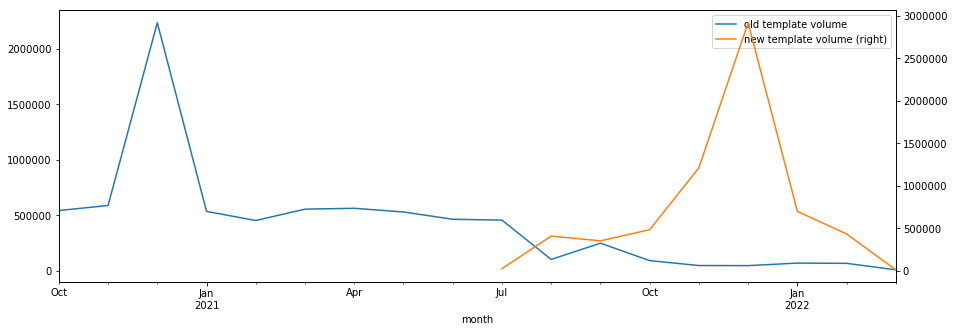

In [239]:
monthly_vol.plot(x='month', secondary_y='new template volume', figsize=(15,5))

#### form sample sizes

In [240]:
print("Dailies:")
print("\tnew template: {:,}".format(len(dailies[dailies['is new template']]['form'].unique())))
print("\told template: {:,}".format(len(dailies[~dailies['is new template']]['form'].unique())))
print()

print("Transactions:")
print("\tnew template: {:,}".format(len(trans[trans['is new template']]['form'].unique())))
print("\told template: {:,}".format(len(trans[~trans['is new template']]['form'].unique())))

Dailies:
	new template: 69
	old template: 492

Transactions:
	new template: 59
	old template: 501


In [241]:
daily_forms = dailies.groupby(['date', 'is new template'])['form'].nunique().reset_index()
daily_forms = daily_forms.pivot(index='date', columns='is new template', values='form').reset_index()
daily_forms.columns = ['date', 'old template', 'new template']

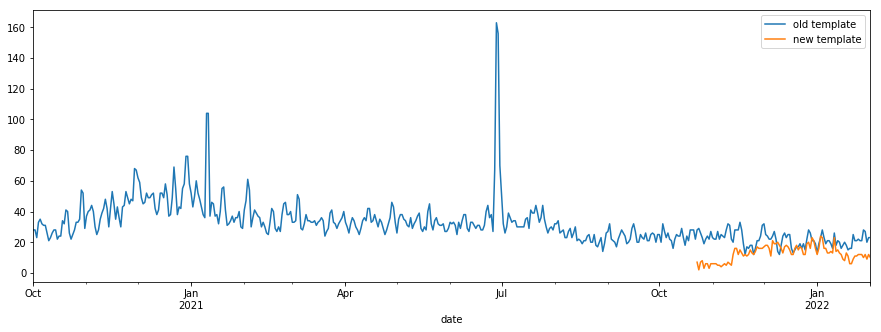

In [242]:
daily_forms.plot(x='date', figsize=(15,5))

In [243]:
daily_trans_forms = trans.groupby(['date', 'is new template'])['form'].nunique().reset_index()
daily_trans_forms = daily_trans_forms.pivot(index='date', columns='is new template', values='form').reset_index()
daily_trans_forms.columns = ['date', 'old template', 'new template']

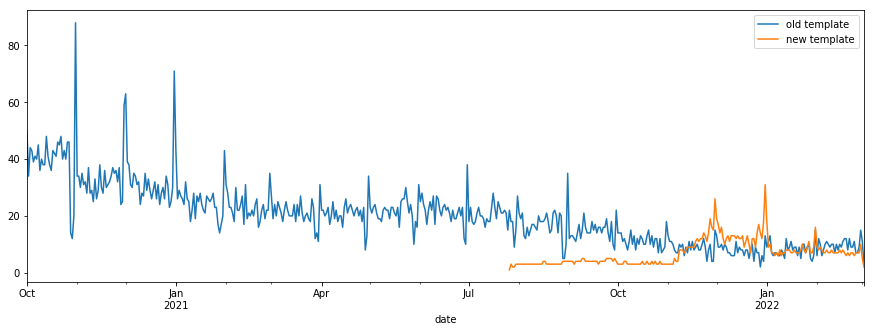

In [244]:
daily_trans_forms.plot(x='date', figsize=(15,5))

#### trans vs dailies one time

In [245]:
daily_onetime = dailies.groupby(['date', 'is new template'])['trans_count_onetime'].sum().reset_index()
daily_onetime = daily_onetime.pivot(index='date', columns='is new template', values='trans_count_onetime').reset_index()
daily_onetime.columns = ['date', 'old template', 'new template']

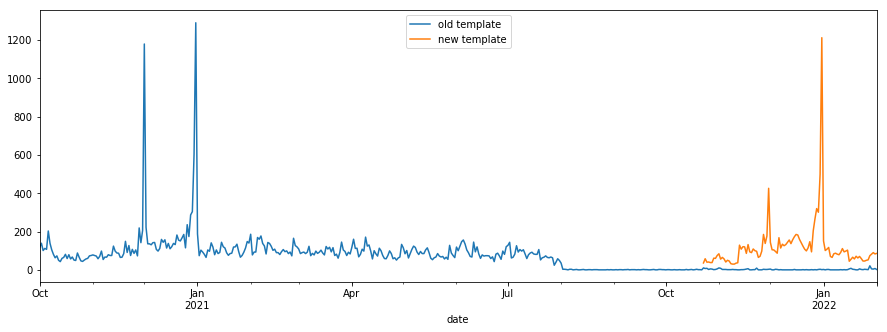

In [246]:
daily_onetime.plot(x='date', figsize=(15,5))

In [247]:
trans_onetime = trans[trans['recurring']==0].groupby(['date', 'is new template'])['id'].nunique().reset_index()
trans_onetime = trans_onetime.pivot(index='date', columns='is new template', values='id').reset_index()
trans_onetime.columns = ['date', 'old template', 'new template']

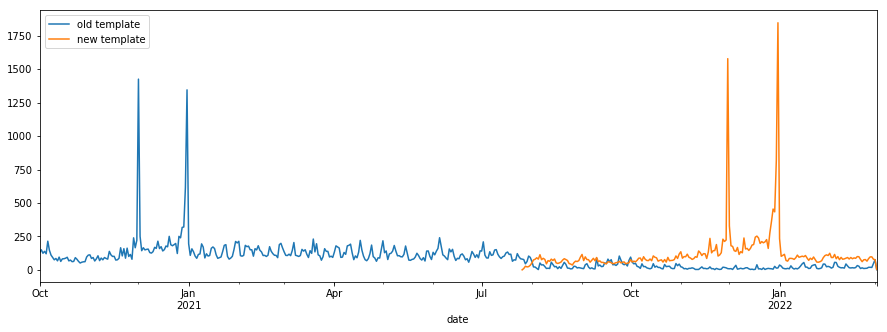

In [248]:
trans_onetime.plot(x='date', figsize=(15,5))

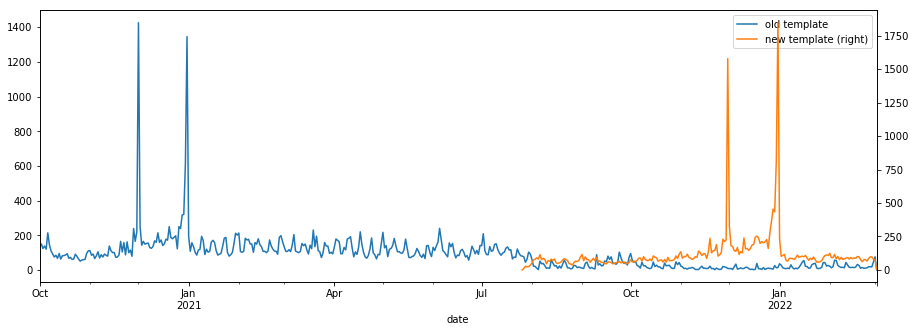

In [249]:
trans_onetime.plot(x='date', secondary_y='new template', figsize=(15,5))

In [250]:
iso_trans = trans[(trans['date']=='2021-02-25')&(trans['is new template'])]
iso_trans.groupby('form')['amount'].sum().reset_index().sort_values('amount').tail()

,form,amount


#### active forms per month

last 90 days, new forms represent 40% by sample size but 6% of the pageviews 

In [251]:
forms_by_month_trans = trans.groupby(['month', 'is new template'])['form'].nunique().reset_index()
forms_by_month_trans = forms_by_month_trans.pivot(index='month', columns='is new template', values='form').reset_index()
forms_by_month_trans.columns = ['month', 'old template forms', 'new template forms']
forms_by_month_trans

,month,old template forms,new template forms
0,2020-10,235.0,NaN
1,2020-11,165.0,NaN
2,2020-12,185.0,NaN
3,2021-01,121.0,NaN
4,2021-02,112.0,NaN
5,2021-03,100.0,NaN
6,2021-04,103.0,NaN
7,2021-05,111.0,NaN
8,2021-06,109.0,NaN
9,2021-07,90.0,4.0


In [252]:
dailies['month'] = dailies['date'].dt.to_period('m')
dailies_traffic_by_month = dailies.groupby(['month', 'is new template'])['views'].sum().reset_index()
dailies_traffic_by_month = dailies_traffic_by_month.pivot(index='month', columns='is new template', values='views').reset_index()
dailies_traffic_by_month.columns = ['month', 'old template', 'new template']

dailies_traffic_by_month['total'] = dailies_traffic_by_month['old template'] + dailies_traffic_by_month['new template']
dailies_traffic_by_month['new template percentage'] = dailies_traffic_by_month['new template'] / dailies_traffic_by_month['total']
dailies_traffic_by_month

,month,old template,new template,total,new template percentage
0,2020-10,109035.0,NaN,NaN,NaN
1,2020-11,174856.0,NaN,NaN,NaN
2,2020-12,233276.0,NaN,NaN,NaN
3,2021-01,59968.0,NaN,NaN,NaN
4,2021-02,69977.0,NaN,NaN,NaN
5,2021-03,74294.0,NaN,NaN,NaN
6,2021-04,66680.0,NaN,NaN,NaN
7,2021-05,97182.0,NaN,NaN,NaN
8,2021-06,87199.0,NaN,NaN,NaN
9,2021-07,68110.0,NaN,NaN,NaN


In [253]:
#dailies.to_csv("dailies.csv", index=False)

# report

In [254]:
#dailies = pd.read_csv("dailies.csv")

In [255]:
def report(df, df_all_trans):
    df.replace(np.inf, np.nan, inplace=True)
    return {
        'form sample size': len(df_all_trans['form'].unique().tolist()),
        'transactions': df_all_trans[df_all_trans['recurring']==0]['id'].nunique() + df['trans_count_recurring'].sum(),
        'transactions per form': df_all_trans.groupby('form')['id'].count().mean(),
        'conversion': df['conversion'].mean(),
        'conversion onetime': df['conversion_onetime'].mean(),
        'conversion recurring': df['conversion_recurring'].mean(),
        'mean transaction onetime': df['trans_vol_onetime'].sum() / df['trans_count_onetime'].sum(),
        'median transaction onetime': df_all_trans[~df_all_trans['is_recurring']]['amount'].median(),
        'mean transaction recurring': df['trans_vol_recurring'].sum() / df['trans_count_recurring'].sum(),
        'median transaction recurring': df_all_trans[df_all_trans['is_recurring']]['amount'].median(),
        'onetime/recurring': df['trans_count_onetime'].sum() / df['trans_count_recurring'].sum(),
        'pageviews': df['views'].sum(),
        'bounce rate': df['bounces'].sum() / df['views'].sum(),
        'transactions one time': len(df_all_trans[~df_all_trans['is_recurring']]),
        'transactions origin recurring': df['trans_count_recurring'].sum(), 
        'transactions all recurring': len(df_all_trans[df_all_trans['is_recurring']])
    }

### new vs old

In [256]:
data_all = {
    'all': report(dailies, trans_all),
    'new template': report(dailies[dailies['is new template']], trans_all[trans_all['is new template']]),
    'old template': report(dailies[~dailies['is new template']], trans_all[~trans_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [257]:
print("{:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2020-10-01 +


,new template,old template
form sample size,59.000000,501.000000
transactions,28196.000000,55756.000000
transactions per form,761.881356,736.894212
conversion,0.123540,0.056956
conversion onetime,0.108169,0.032847
conversion recurring,0.015371,0.024109
mean transaction onetime,265.579917,162.278597
median transaction onetime,51.500000,50.000000
mean transaction recurring,83.249202,41.122442
median transaction recurring,25.750000,19.570000


#### month over month

In [258]:
trans_all['month'] = trans_all['date'].dt.to_period('M')

In [259]:
for m in dailies.month.unique():
    this_month = dailies[dailies['month']==m]
    this_trans = trans_all[trans_all['month']==m]
    
    this_data = {
        'all': report(this_month, this_trans),
        'new template': report(this_month[this_month['is new template']], this_trans[this_trans['is new template']]),
        'old template': report(this_month[~this_month['is new template']], this_trans[~this_trans['is new template']])
    }
    
    df = pd.DataFrame(this_data)
    df = df.transpose().copy()

    df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
    df['pageviews'] = df['pageviews_perc']
    df['transactions_perc'] = df['transactions'] / df['transactions']['all']

    df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
    
    print(m)
    print(df.transpose().drop('all', axis=1))
    print("-"*40)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


2020-10
                               new template  old template
form sample size                        0.0    300.000000
transactions                            0.0   4480.000000
transactions per form                   NaN     60.210000
conversion                              NaN      0.085271
conversion onetime                      NaN      0.039133
conversion recurring                    NaN      0.046138
mean transaction onetime                NaN    125.034466
median transaction onetime              NaN     50.000000
mean transaction recurring              NaN     26.330756
median transaction recurring            NaN     19.000000
onetime/recurring                       NaN      1.577835
pageviews                               0.0      1.000000
bounce rate                             NaN      0.656734
transactions one time                   0.0   2919.000000
transactions origin recurring           0.0   1561.000000
transactions all recurring              0.0  15144.000000
------

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/home/ubuntu/anac

2021-01
                               new template  old template
form sample size                        0.0    363.000000
transactions                            0.0   5077.000000
transactions per form                   NaN     61.986226
conversion                              NaN      0.056943
conversion onetime                      NaN      0.034548
conversion recurring                    NaN      0.022395
mean transaction onetime                NaN    126.315524
median transaction onetime              NaN     50.000000
mean transaction recurring              NaN     29.375091
median transaction recurring            NaN     19.570000
onetime/recurring                       NaN      3.491927
pageviews                               0.0      1.000000
bounce rate                             NaN      0.641142
transactions one time                   0.0   4148.000000
transactions origin recurring           0.0    929.000000
transactions all recurring              0.0  18353.000000
------

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/ubuntu/anac

2021-06
                               new template  old template
form sample size                        0.0    378.000000
transactions                            0.0   4123.000000
transactions per form                   NaN     63.968254
conversion                              NaN      0.055337
conversion onetime                      NaN      0.037900
conversion recurring                    NaN      0.017437
mean transaction onetime                NaN    132.882411
median transaction onetime              NaN     50.000000
mean transaction recurring              NaN     35.056144
median transaction recurring            NaN     19.570000
onetime/recurring                       NaN      4.310345
pageviews                               0.0      1.000000
bounce rate                             NaN      0.737612
transactions one time                   0.0   3485.000000
transactions origin recurring           0.0    638.000000
transactions all recurring              0.0  20695.000000
------

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/ubuntu/anac

2021-11
                               new template  old template
form sample size                  34.000000    400.000000
transactions                    5719.000000    531.000000
transactions per form            232.735294     49.245000
conversion                         0.146140      0.034348
conversion onetime                 0.136664      0.014392
conversion recurring               0.009476      0.019956
mean transaction onetime         205.948429    179.038788
median transaction onetime        51.500000     20.600000
mean transaction recurring        45.662222     28.681864
median transaction recurring      25.750000     19.570000
onetime/recurring                  8.080556      0.372881
pageviews                          0.934309      0.065691
bounce rate                        0.390625      0.647548
transactions one time           5359.000000    354.000000
transactions origin recurring    360.000000    177.000000
transactions all recurring      2554.000000  19344.000000
------

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


### all past 90 days

In [260]:
ninety_days_ago = dailies['date'].max() - datetime.timedelta(90)
last_90 = dailies[dailies['date']>=ninety_days_ago]
last_90_all = trans_all[trans_all['date']>=ninety_days_ago]

In [261]:
last_90['date'].min(), last_90_all['date'].min()

(Timestamp('2021-11-03 00:00:00'), Timestamp('2021-11-03 00:00:00'))

In [262]:
data_last_90 = {
    'all': report(last_90, last_90_all),
    'new template': report(last_90[last_90['is new template']], last_90_all[last_90_all['is new template']]),
    'old template': report(last_90[~last_90['is new template']], last_90_all[~last_90_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [263]:
print("{:%Y-%m-%d} +".format(last_90['date'].min()))
df = pd.DataFrame(data_last_90)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2021-11-03 +


,new template,old template
form sample size,58.000000,416.000000
transactions,21257.000000,2437.000000
transactions per form,579.000000,184.725962
conversion,0.124928,0.027492
conversion onetime,0.109117,0.010607
conversion recurring,0.015811,0.016885
mean transaction onetime,266.621502,143.941333
median transaction onetime,66.000000,25.000000
mean transaction recurring,85.048833,28.477768
median transaction recurring,25.750000,19.570000


In [264]:
trans_last_90 = trans[trans['date']>=ninety_days_ago]
trans_last_90[['is_recurring', 'is new template', 'amount']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,25.000
1,False,True,66.000
2,True,False,20.000
3,True,True,25.375


### all past 30 days

In [265]:
thirty_days_ago = dailies['date'].max() - datetime.timedelta(30)
last_30 = dailies[dailies['date']>=thirty_days_ago]
last_30_all = trans_all[trans_all['date']>=thirty_days_ago]

In [266]:
last_30['date'].min(), last_30['date'].max()

(Timestamp('2022-01-02 00:00:00'), Timestamp('2022-02-01 00:00:00'))

In [267]:
last_30['date'].min(), last_30_all['date'].min()

(Timestamp('2022-01-02 00:00:00'), Timestamp('2022-01-02 00:00:00'))

In [268]:
data_last_30 = {
    'all': report(last_30, last_30_all),
    'new template': report(last_30[last_30['is new template']], last_30_all[last_30_all['is new template']]),
    'old template': report(last_30[~last_30['is new template']], last_30_all[~last_30_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [269]:
print("{:%Y-%m-%d} +".format(last_30['date'].min()))
df = pd.DataFrame(data_last_30)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2022-01-02 +


,new template,old template
form sample size,38.000000,403.000000
transactions,6127.000000,1480.000000
transactions per form,359.236842,95.935484
conversion,0.088049,0.028547
conversion onetime,0.061351,0.009744
conversion recurring,0.026698,0.018803
mean transaction onetime,166.371623,120.205769
median transaction onetime,51.500000,25.000000
mean transaction recurring,106.783864,29.028293
median transaction recurring,25.750000,19.570000


In [270]:
trans_last_30 = trans[trans['date']>=thirty_days_ago]
trans_last_30[['is_recurring', 'is new template', 'amount']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,25.00
1,False,True,51.50
2,True,False,20.00
3,True,True,25.75


### embeds

##### all embeds

In [271]:
dailies.groupby('is embed')['conversion'].mean()

is embed
False    0.061169
True     0.088658
Name: conversion, dtype: float64

In [272]:
data_all = {
    'all': report(dailies, trans_all),
    'embed': report(dailies[dailies['is embed']], trans_all[trans_all['is embed']]),
    'not embed': report(dailies[~dailies['is embed']], trans_all[~trans_all['is embed']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [273]:
print("Embeds {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Embeds 2020-10-01 +


,embed,not embed
form sample size,2.000000,558.000000
transactions,2776.000000,81176.000000
transactions per form,11249.500000,701.856631
conversion,0.088658,0.061169
conversion onetime,0.029687,0.038780
conversion recurring,0.058972,0.022389
mean transaction onetime,104.450394,192.017686
median transaction onetime,50.000000,51.500000
mean transaction recurring,27.728686,51.072183
median transaction recurring,19.000000,19.570000


##### new template embeds

In [274]:
dailies[dailies['is new template']].groupby('is embed')['conversion'].mean()

is embed
False    0.12354
Name: conversion, dtype: float64

In [275]:
data_all = {
    'all': report(dailies, trans_all),
    'embed': report(dailies[(dailies['is embed'])&(dailies['is new template'])], trans_all[(trans_all['is embed'])&(trans_all['is new template'])]),
    'not embed': report(dailies[(~dailies['is embed'])&(dailies['is new template'])], trans_all[(~trans_all['is embed'])&(trans_all['is new template'])])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [276]:
print("Embeds (new template) {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Embeds (new template) 2020-10-01 +


,embed,not embed
form sample size,0.0,59.000000
transactions,0.0,28196.000000
transactions per form,NaN,761.881356
conversion,NaN,0.123540
conversion onetime,NaN,0.108169
conversion recurring,NaN,0.015371
mean transaction onetime,NaN,265.579917
median transaction onetime,NaN,51.500000
mean transaction recurring,NaN,83.249202
median transaction recurring,NaN,25.750000


In [277]:
trans[trans['is new template']][['amount', 'is_recurring', 'is embed']].groupby(['is_recurring', 'is embed'])['amount'].median().reset_index()

,is_recurring,is embed,amount
0,False,False,51.50
1,True,False,25.75


### Forms w/ trans new & old

In [278]:
new_template_forms = dailies[dailies['is new template']]['form'].unique().tolist()
old_template_overlap = dailies[(~dailies['is new template'])&(dailies['form'].isin(new_template_forms))]['form'].unique().tolist()

print("all forms: {}".format(len(dailies['form'].unique())))
print("new template forms: {}".format(len(new_template_forms)))
print("old template overlap forms: {}".format(len(old_template_overlap)))

all forms: 561
new template forms: 69
old template overlap forms: 0


In [279]:
dailies_overlap = dailies[dailies['form'].isin(old_template_overlap)]
trans_all_overlap = trans_all[trans_all['form'].isin(old_template_overlap)]

In [280]:
data_all = {
    'all': report(dailies_overlap, trans_all_overlap),
    'new template': report(dailies_overlap[dailies_overlap['is new template']], trans_all_overlap[trans_all_overlap['is new template']]),
    'old template': report(dailies_overlap[~dailies_overlap['is new template']], trans_all_overlap[~trans_all_overlap['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [281]:
print("Forms w/ transaction in new & old {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Forms w/ transaction in new & old 2020-10-01 +


,new template,old template
form sample size,0.0,0.0
transactions,0.0,0.0
transactions per form,NaN,NaN
conversion,NaN,NaN
conversion onetime,NaN,NaN
conversion recurring,NaN,NaN
mean transaction onetime,NaN,NaN
median transaction onetime,NaN,NaN
mean transaction recurring,NaN,NaN
median transaction recurring,NaN,NaN


In [282]:
trans[trans['form'].isin(old_template_overlap)][['amount', 'is_recurring', 'is new template']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
